<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter11/conv_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Conv Autoencoders
in vanilla autoencoder we used fully connected since we have small (28x28) single channel images so we could autoencode vectors of 784 elements  
in order to scale up to larger image with multi channel, we'll employ the inductive bias in conv nets in order to save parameters.

so we'll learn how to implement a conv AE. but will stick to the simlpe MNIST dataset for the sake of comparison

In [1]:
# !pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

trn_ds = MNIST('~/datasets/MNIST/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('~/datasets/MNIST/content/', transform=img_transform, train=False, download=True)

batch_size = 128
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [3]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=3, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2), nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1), nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model = ConvAutoEncoder().to(device)
# !pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros(2,1,28,28));


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

In [4]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

In [5]:
@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

In [6]:
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [7]:
num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')
        
    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        
    log.report_avgs(epoch+1)

EPOCH: 1.000	trn_loss: 0.440	val_loss: 0.283	(10.06s - 40.23s remaining)
EPOCH: 2.000	trn_loss: 0.141	val_loss: 0.102	(20.18s - 30.27s remaining)
EPOCH: 3.000	trn_loss: 0.090	val_loss: 0.080	(30.22s - 20.15s remaining)
EPOCH: 4.000	trn_loss: 0.077	val_loss: 0.070	(40.35s - 10.09s remaining)
EPOCH: 5.000	trn_loss: 0.070	val_loss: 0.065	(50.54s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 3073.94it/s]


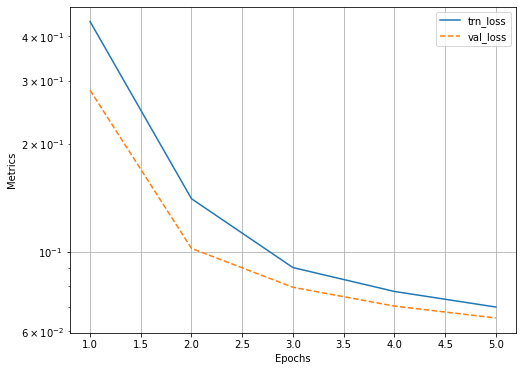

In [8]:
log.plot_epochs(log=True)

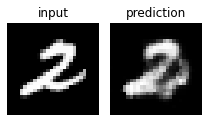

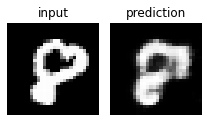

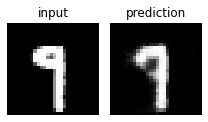

In [9]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1, 2, figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

## Grouping similar images using t-SNE
we will plot embedding (bottleneck) vectors in a 2-dimensional space. We can reduce the 64-dimensional vector of convolutional autoencoder to a 2dimensional space by using a technique called t-SNE

In [10]:
# lists to store the latent vectors and their corresponding labels
latent_vectors = []
classes = []

In [11]:
# populate the lists from the validation set
for im,clss in val_dl:
    latent_vectors.append(model.encoder(im).view(len(im),-1))
    classes.extend(clss)

In [12]:
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(2)

In [14]:
clustered = tsne.fit_transform(latent_vectors)

/home/guy/anaconda3/envs/ptvit/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/guy/anaconda3/envs/ptvit/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


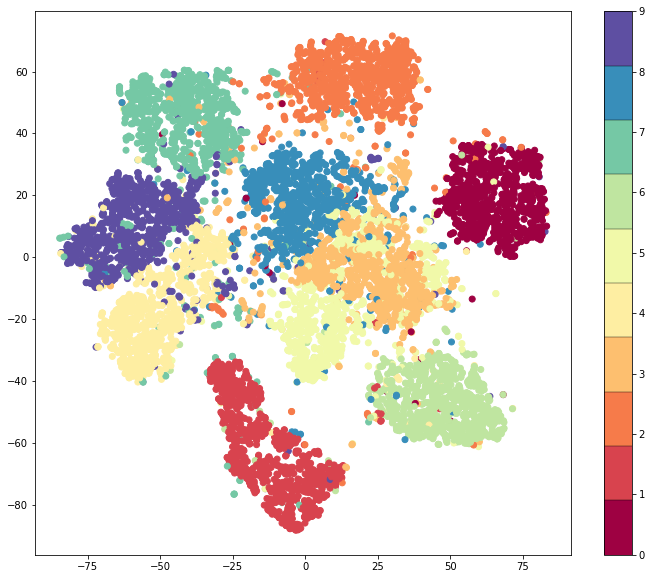

In [15]:
fig = plt.figure(figsize=(12,10))
cmap = plt.get_cmap('Spectral', 10)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)

We can see that images of the same class are clustered together, which reinforces our understanding that the bottleneck layer has values in such a way that images that look similar will have similar values.

## Understanding Variational Autoencoders
we have learned that when we take embeddings of images that fall in a given cluster, we can re-construct (decode) them. However, what if an embedding (a latent vector) falls in between two clusters? There is no guarantee that we would generate realistic images. Variational autoencoders come in handy in such a scenario.  

Before we dive into building a variational autoencoder, let's explore the limitations of generating images from embeddings that do not fall into a cluster (or in the middle of different clusters). First, we generate images by sampling vectors

In [16]:
latent_vectors = []
classes = []
for im,clss in val_dl:
    latent_vectors.append(model.encoder(im))
    classes.extend(clss)
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy().reshape(10000, -1)

In [17]:
rand_vectors = []
for col in latent_vectors.transpose(1,0):
    mu, sigma = col.mean(), col.std()
    rand_vectors.append(sigma*torch.randn(1,100) + mu)

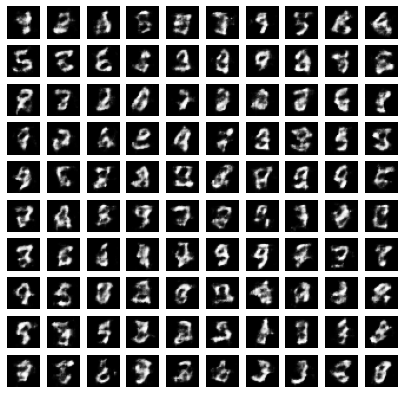

In [18]:
rand_vectors = torch.cat(rand_vectors).transpose(1,0).to(device)
fig, ax = plt.subplots(10,10,figsize=(7,7)); ax = iter(ax.flat)
for p in rand_vectors:
    img = model.decoder(p.reshape(1,64,2,2)).view(28,28)
    show(img, ax=next(ax))

We can see from the preceding output that when we plot images that were generated from the mean and the noise-added standard deviation of columns of known vectors, we got images that are less clear than before. This is a realistic scenario, as we would not know beforehand about the range of embedding vectors that would generate realistic pictures.


Variational Autoencoders (VAE) help us resolve this problem by generating vectors that have a mean of 0 and a standard deviation of 1, thereby ensuring that we generate images that have a mean of 0 and a standard deviation of 1.